# Assignment 4 -- Time Dependant Problems
## ZIJIN SU 22085664

This notebook will investigate the numerical solution of a time-dependent heat-diffusion problem on a two-dimensional square domain $[-1,1] \times [-1,1]$. At the initial time $t = 0$, one side of the plate is held at a temperature of $u = 5$ while the remaining three boundaries are fixed at $u = 0$. The temperature field evolves according to the heat equation $u_t = \Delta u$.

The primary objective is to determine the time $t^*$ at which the temperature at the centre of the plate first reaches $u = 1$. To compute this, a finite-difference spatial discretisation is combined with both explicit and implicit time-stepping schemes. The numerical stability of each method will be examined, and, by refining the spatial grid, the convergence of the computed $t^*$ toward the reference value $t^* = 0.424011387033$ will be assessed.

Additionally, this notebook will explore a GPU-accelerated implementation of the explicit scheme to evaluate potential performance improvements.



# First to introduce Finite Difference Time-Stepping that will be used in following evaluation

Finite difference methods allow partial differential equations to be approximated on discrete spatial and temporal grids. In this assignment,consider the two-dimensional heat equation

$$(u_t = u_{xx} + u_{yy}),$$

posed on a square domain. The second spatial derivatives are approximated using the standard central-difference five-point stencil:

$$
\Delta u(i,j) \approx 
\frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{\Delta x^2}.
$$

Time-stepping can be performed using either explicit (Forward Euler) or implicit (Backward Euler) schemes.


### Explicit scheme

Using the approximation  
$$u_t \approx \frac{u_{t+1} - u_t}{\Delta t},$$  
and evaluating the Laplacian at time $t$, then obtain

$$
u_{t+1}(i,j)
= u_t(i,j)
+ C \big(
u_t(i+1,j)
+ u_t(i-1,j)
+ u_t(i,j+1)
+ u_t(i,j-1)
- 4u_t(i,j)
\big),
$$

where the Courant number is $C = \frac{\Delta t}{\Delta x^2}$.  
This method is conditionally stable and requires $C \le \frac{1}{4}$ in two dimensions.


### Implicit scheme

If the Laplacian is evaluated at time $t+1$, the Backward Euler method gives

$$
\frac{u_{t+1}(i,j) - u_t(i,j)}{\Delta t}
=
\Delta u_{t+1}(i,j).
$$

This can be written compactly in matrix form as

$$
(I - \Delta t\,A)\,u_{t+1} = u_t,
$$

where $A$ is the discrete Laplacian operator.  
The implicit scheme is unconditionally stable, allowing larger time steps.


Together, these techniques evolve the temperature field in time and investigate the stability and accuracy of each method.





## Part 1 -- Explicit Time Stepping

In the explicit (Forward Euler) method, the temperature field is updated using only information from the previous time step. The computational grid spans the domain $[-1,1]\times[-1,1]$. With $N$ interior intervals, the spatial step size is

$$
\Delta x = \frac{2}{N}.
$$

The centre of the plate corresponds to the grid index

$$
(i_c, j_c) = \left(\frac{N}{2}, \frac{N}{2}\right).
$$

At each time step, the explicit scheme updates the temperature field and tracks when the centre point first reaches the target value $u = 1$.

In [46]:
from numba import njit,prange,cuda
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numba
from tqdm import tqdm
%matplotlib inline

In [47]:
#python version
def explicit_step_python(u_old,u_new,N,C):
    for i in range(1,N-1):
        for j in range(1,N-1):
            u_new[i,j] = (u_old[i,j]+ C * (u_old[i+1,j] + u_old[i-1,j] + u_old[i,j+1] + u_old[i,j-1] - 4* u_old[i,j]))
    return u_new

def forward_euler_python(N,max_time = 0.45,C=0.25):
    dx = 2.0/(N-1)
    dt = C*dx*dx
    timesteps = int(max_time/dt)
    u_old = np.zeros((N,N))
    u_new = np.zeros((N,N))
    #boundary
    u_old[:,0] = 5.0
    u_new[:,0] = 5.0
    center = (N)//2
    central_temps = np.empty(timesteps)
    reached_time = None
    
    for t in range (timesteps):
        u_new = explicit_step_python(u_old,u_new,N,C)
        u_new[:,0] = 5.0
        central_temps[t] = u_new[center,center]
        if reached_time is  None and u_new[center,center] >=1.0:
            reached_time = t*dt
        u_old, u_new = u_new, u_old 

    return central_temps,reached_time,dx,dt,u_old

# cpu version
@njit(parallel=True)
def explicit_step_cpu(u_old, u_new, N, C):
    for i in prange(1, N-1):
        for j in range(1, N-1):
            u_new[i,j] = (
                u_old[i,j] +
                C * (
                    u_old[i+1,j] + u_old[i-1,j] +
                    u_old[i,j+1] + u_old[i,j-1] -
                    4.0*u_old[i,j]
                )
            )
    return u_new

def forward_euler_cpu(N, max_time=0.45, C=0.25):
    dx = 2.0/(N-1)
    dt = C * dx*dx
    timesteps = int(max_time/dt)

    u_old = np.zeros((N, N))
    u_new = np.zeros((N, N))

    # left boundary = 5
    u_old[:, 0] = 5.0
    u_new[:, 0] = 5.0

    center = (N-1)//2
    central_temps = np.zeros(timesteps)
    reached_time = None

    for t in range(timesteps):
        u_new = explicit_step_cpu(u_old, u_new, N, C)
        u_new[:, 0] = 5.0

        central_temps[t] = u_new[center, center]

        if reached_time is None and u_new[center,center] >= 1.0:
            reached_time = t * dt

        u_old, u_new = u_new, u_old

    return central_temps, reached_time, dx, dt, u_old

# GPU version






def time_central_val(sizes,max_time=0.5,C=0.25,solver_func=None,):
    assert solver_func is not None, "You must pass a solver function."
    times = []
    temps = []
    dt_list = []
    dx_list = []
    for N in sizes:
        central_temps, t_star, dx, dt,_ = solver_func(
            N,
            max_time=max_time,
            C=C
        )

        times.append(t_star)
        temps.append(central_temps)
        dx_list.append(dx)
        dt_list.append(dt)

    return times, temps, dx_list, dt_list    

In [48]:
%%time
central_temps, t_star, dx, dt,u_final = forward_euler_cpu(231)
print(f"The time taken for the central point to reach a heat of 1 is {t_star:.12f}")

The time taken for the central point to reach a heat of 1 is 0.423988657845
CPU times: user 1.1 s, sys: 4.97 s, total: 6.07 s
Wall time: 2.09 s


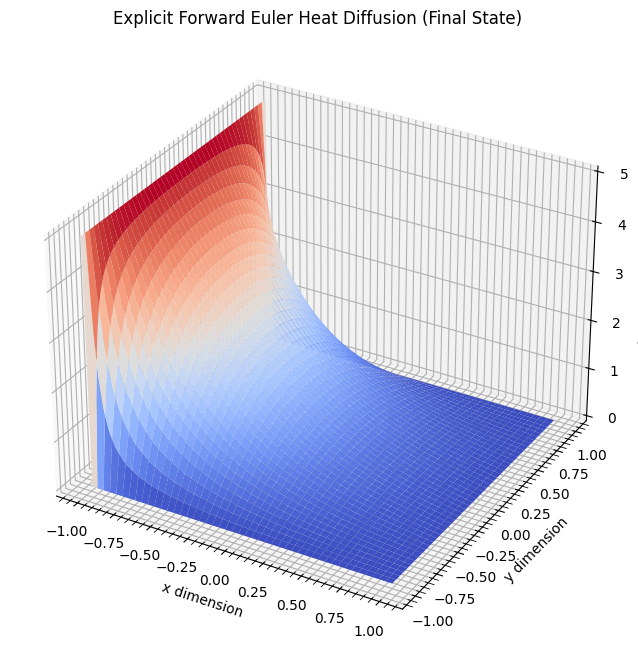

The t* at which the central temperature reaches 1 in this implementation is: 0.423988657845


In [49]:
ticks = np.linspace(-1,1,u_final.shape[0])
X,Y= np.meshgrid(ticks,ticks)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surface = ax.plot_surface(X,Y,u_final,antialiased = True, cmap = 'coolwarm')
ax.set_xlabel('x dimension')
ax.set_ylabel('y dimension')
ax.set_zlabel('u(x,y) temperature')
ax.set_title('Explicit Forward Euler Heat Diffusion (Final State)')
ax.minorticks_on()
plt.show()
print(f"The t* at which the central temperature reaches 1 in this implementation is: {t_star:.12}")


In [50]:
# test the time cost for different size of the grid NxN
Ns = [11,21,31,41,51,61,71,81,91,101,151,181,201,231]
times,temps,dx,dt = time_central_val(Ns,solver_func=forward_euler_cpu)

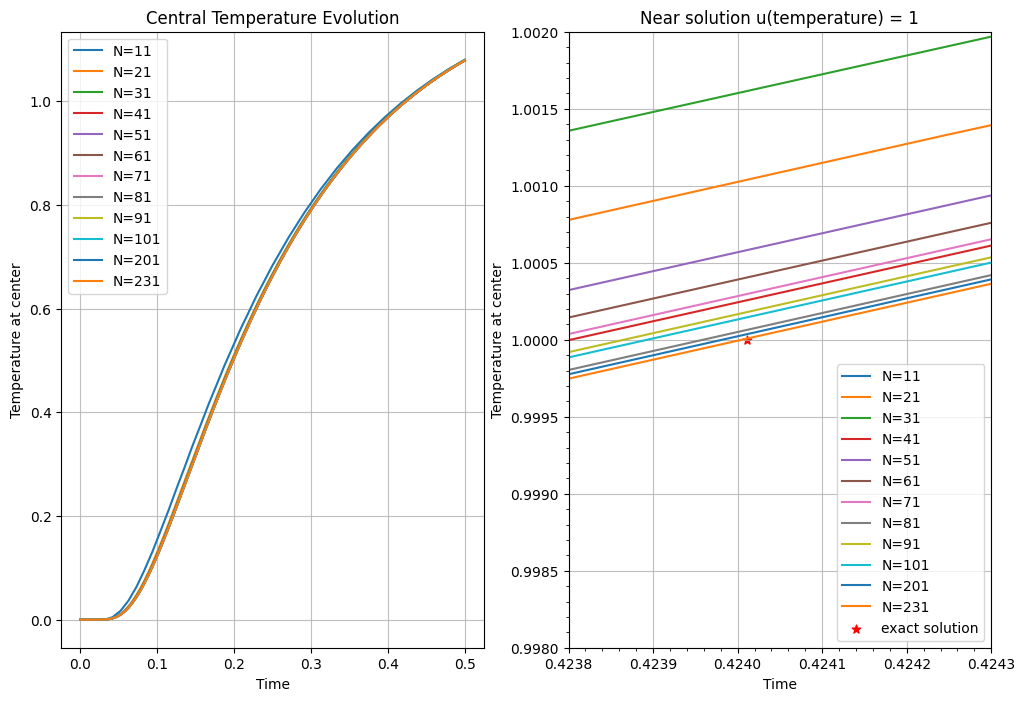

In [51]:
fig,axs = plt.subplots(1,2,figsize=(12,8))
ax=axs[0]
for i, N in enumerate(Ns):
    t_axis = np.linspace(0,0.5,len(temps[i]))
    ax.plot(t_axis,temps[i],label=f"N={N}")
ax.set_title("Central Temperature Evolution")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature at center")
ax.legend()
ax.grid(True,alpha=0.8) 
# Near solution, zoom in for better evaluation
ax= axs[1]
for i, N in enumerate(Ns):
    t_axis = np.linspace(0,0.5,len(temps[i]))
    ax.plot(t_axis,temps[i],label=f"N={N}")
ax.set_title("Near solution u(temperature) = 1")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature at center")
ax.scatter(0.424011387033, 1, marker='*', s=40, color='red',label='exact solution')
ax.minorticks_on()
ax.set_xlim(0.4238,0.4243)
ax.set_ylim(0.998,1.002)
ax.legend()
ax.grid(True,alpha=0.8) 


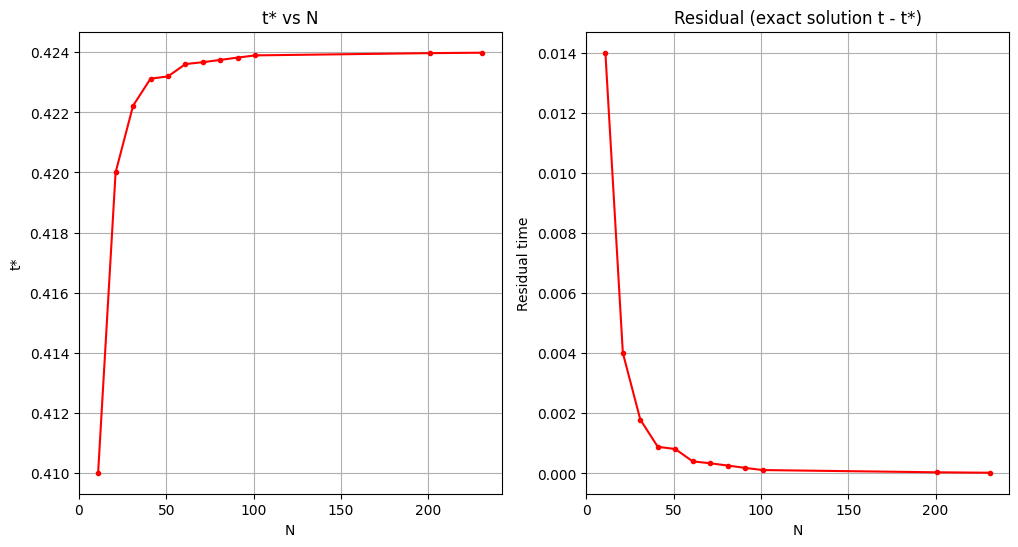

In [52]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax=axs[0]
ax.plot(Ns, times, marker='o',color = 'red',markersize=3)
ax.set_title("t* vs N")
ax.set_xlabel("N")
ax.set_ylabel("t*")
ax.grid(True)
t_true = 0.424011387033
ax=axs[1]
ax.plot(Ns, t_true - np.array(times), marker='o',color='red',markersize=3)
ax.set_title("Residual (exact solution t - t*)")
ax.set_xlabel("N size")
ax.set_ylabel("Residual time")
ax.grid(True)


From those figures, the recorded heating time is systematically underestimated, since the measurement stops once the central temperature exceeds $1$. The size of this error depends on the timestep $ \Delta t $, which decreases rapidly as the spatial interval $ \Delta x $ becomes smaller, leading to the observed decay of the residual.
At low $N$, the explicit scheme over-propagates heat due to its reliance on local information, causing the temperature to cross the $1$ threshold earlier than the true physical behaviour. This explains the larger underestimation at coarse discretisations.